Analyze temporal trends and structural shifts in Aadhaar biometric, demographic, and enrollment activity to identify sustained changes, emerging patterns, and periods of elevated system stress.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


In [2]:
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
INTERMEDIATE_PATH = PROJECT_ROOT / "data" / "intermediate"

biometric_df = pd.read_parquet(INTERMEDIATE_PATH / "biometric_base.parquet")
demographic_df = pd.read_parquet(INTERMEDIATE_PATH / "demographic_base.parquet")
enrollment_df = pd.read_parquet(INTERMEDIATE_PATH / "enrollment_base.parquet")


In [4]:
COLUMN_ROLES = {
    "biometric": ["bio_age_5_17", "bio_age_17_"],
    "demographic": ["demo_age_5_17", "demo_age_17_"],
    "enrollment": ["age_0_5", "age_5_17", "age_18_greater"]
}

for df in [biometric_df, demographic_df, enrollment_df]:
    df["date"] = pd.to_datetime(
        df["date"],
        dayfirst=True,
        errors="coerce"
    )


In [5]:
for name, df in zip(
    ["biometric", "demographic", "enrollment"],
    [biometric_df, demographic_df, enrollment_df]
):
    print(name)
    print("NaT count:", df["date"].isna().sum())
    print("Date range:", df["date"].min(), "→", df["date"].max())
    print("-" * 40)


biometric
NaT count: 0
Date range: 2025-03-01 00:00:00 → 2025-12-29 00:00:00
----------------------------------------
demographic
NaT count: 0
Date range: 2025-03-01 00:00:00 → 2025-12-29 00:00:00
----------------------------------------
enrollment
NaT count: 0
Date range: 2025-03-02 00:00:00 → 2025-12-31 00:00:00
----------------------------------------


In [6]:
def aggregate_daily(df, numeric_cols):
    return (
        df.groupby("date")[numeric_cols]
        .sum()
        .reset_index()
        .sort_values("date")
    )

bio_daily = aggregate_daily(biometric_df, COLUMN_ROLES["biometric"])
demo_daily = aggregate_daily(demographic_df, COLUMN_ROLES["demographic"])
enr_daily = aggregate_daily(enrollment_df, COLUMN_ROLES["enrollment"])


In [7]:
def plot_rolling_trend(df, column, window=14, title=""):
    plt.figure(figsize=(10, 4))
    plt.plot(df["date"], df[column], alpha=0.3, label="Daily")
    plt.plot(
        df["date"],
        df[column].rolling(window).median(),
        linewidth=2,
        label=f"{window}-Day Rolling Median"
    )
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()


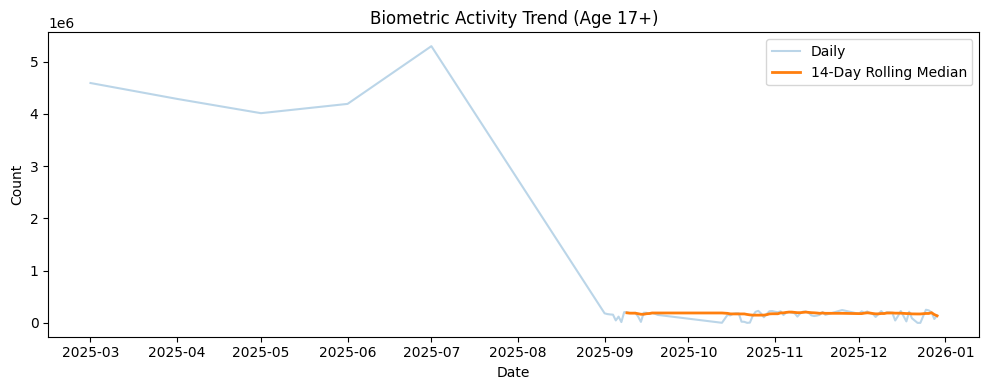

In [8]:
plot_rolling_trend(
    bio_daily,
    "bio_age_17_",
    title="Biometric Activity Trend (Age 17+)"
)


In [19]:
DATASETS = {
    "Biometric": {
        "df": bio_daily,
        "columns": COLUMN_ROLES["biometric"]
    },
    "Demographic": {
        "df": demo_daily,
        "columns": COLUMN_ROLES["demographic"]
    },
    "Enrollment": {
        "df": enr_daily,
        "columns": COLUMN_ROLES["enrollment"]
    }
}


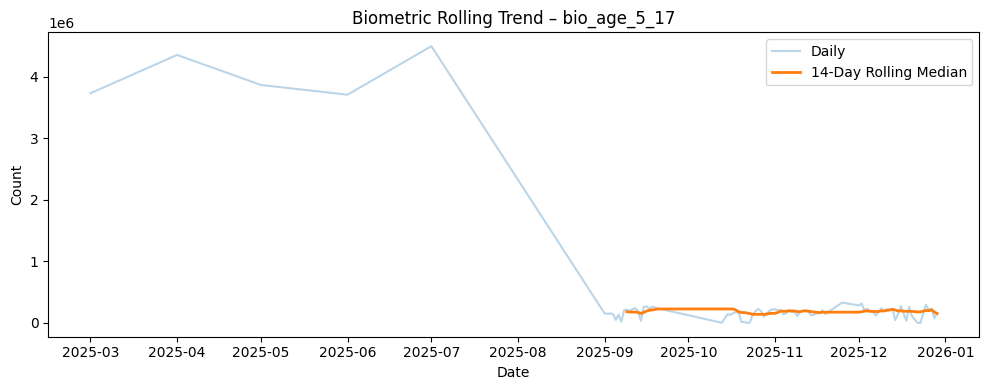

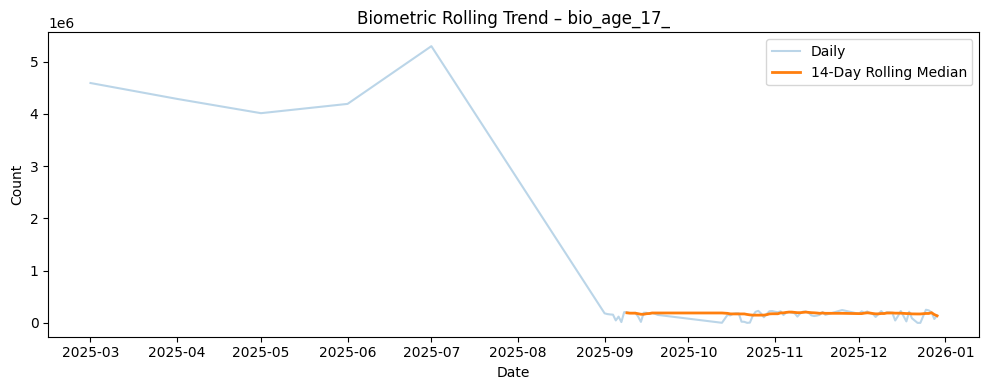

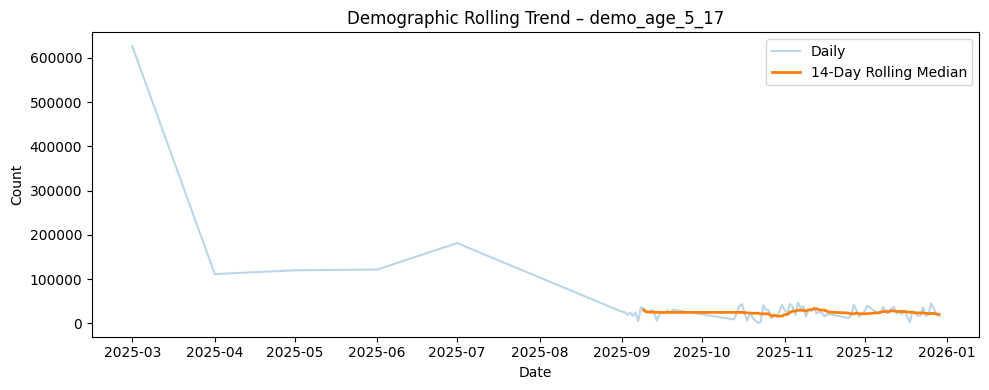

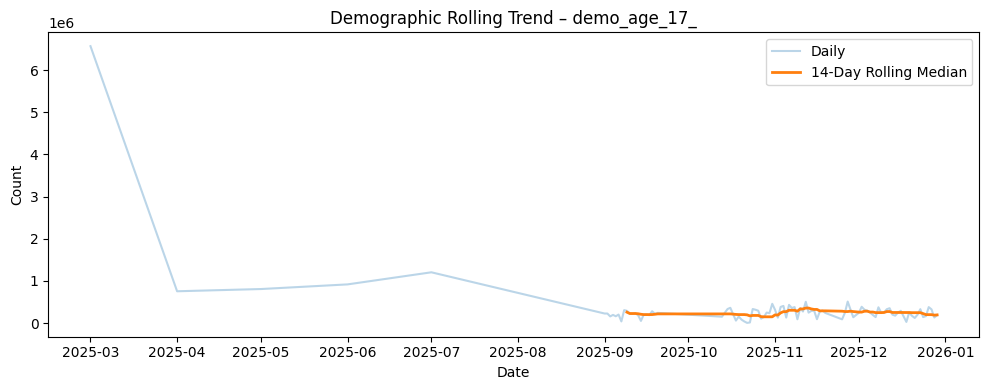

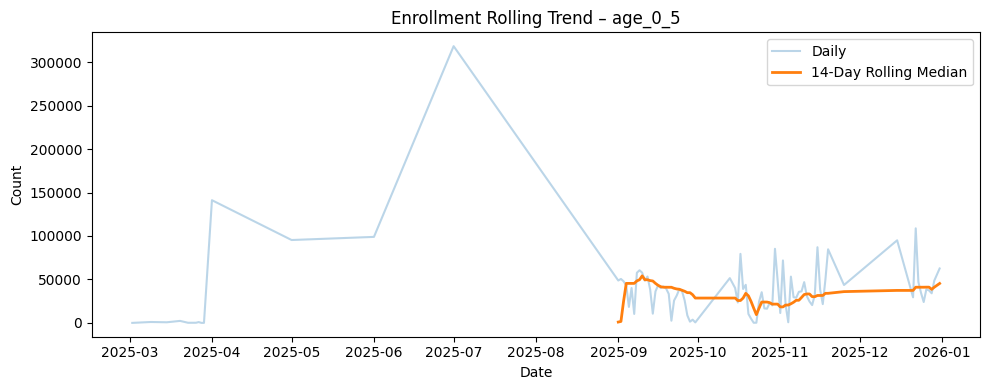

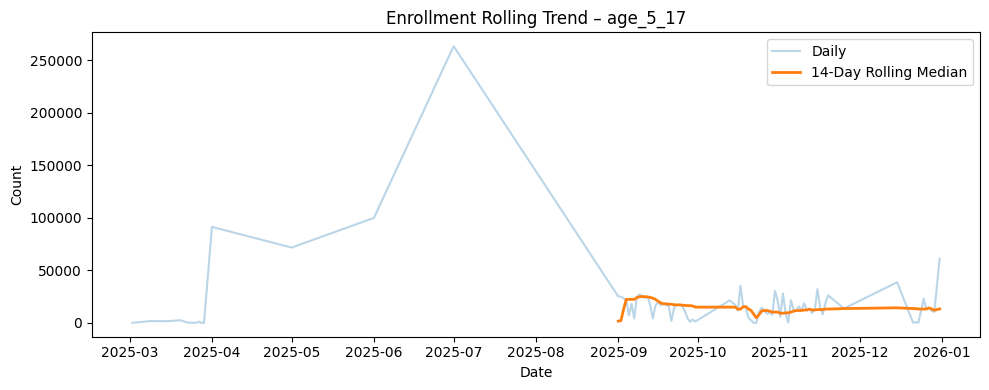

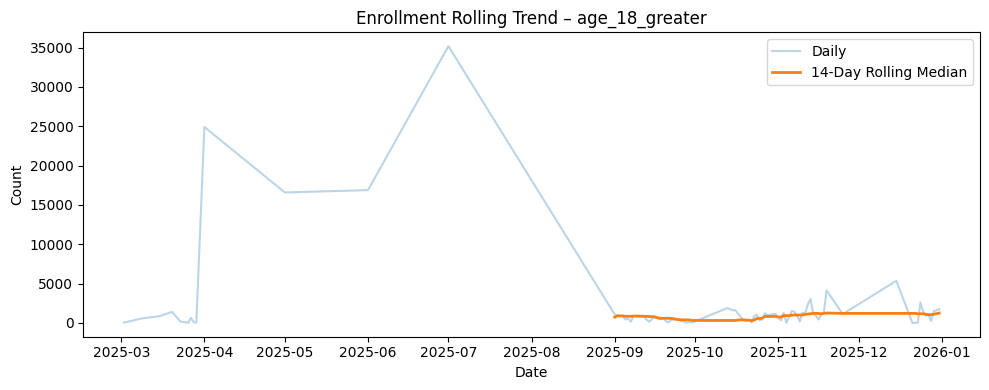

In [20]:
for dataset_name, config in DATASETS.items():
    df = config["df"]
    cols = config["columns"]
    
    for col in cols:
        plot_rolling_trend(
            df,
            col,
            window=14,
            title=f"{dataset_name} Rolling Trend – {col}"
        )


Rolling median trends across biometric, demographic, and enrollment datasets reveal periods of sustained change, distinguishing isolated spikes from long-term system behavior.

In [11]:
from scipy.stats import kendalltau

def mann_kendall_test(df, column):
    time_index = np.arange(len(df))
    tau, p_value = kendalltau(time_index, df[column])
    return tau, p_value


In [12]:
for name, df, col in [
    ("Biometric", bio_daily, "bio_age_17_"),
    ("Demographic", demo_daily, "demo_age_17_"),
    ("Enrollment", enr_daily, "age_0_5")
]:
    tau, p = mann_kendall_test(df, col)
    print(f"{name}: Kendall Tau={tau:.3f}, p-value={p:.4e}")


Biometric: Kendall Tau=-0.036, p-value=6.1980e-01
Demographic: Kendall Tau=-0.016, p-value=8.1444e-01
Enrollment: Kendall Tau=0.109, p-value=1.2405e-01


In [13]:
def detect_change_points(series, threshold=5):
    mean = series.mean()
    cusum = np.cumsum(series - mean)
    return np.where(np.abs(cusum) > threshold * series.std())[0]


In [14]:
def plot_change_points(df, column, title):
    change_points = detect_change_points(df[column])
    
    plt.figure(figsize=(10, 4))
    plt.plot(df["date"], df[column], label="Daily")
    
    if len(change_points) > 0:
        plt.scatter(
            df.iloc[change_points]["date"],
            df.iloc[change_points][column],
            color="red",
            label="Change Points"
        )
    
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()


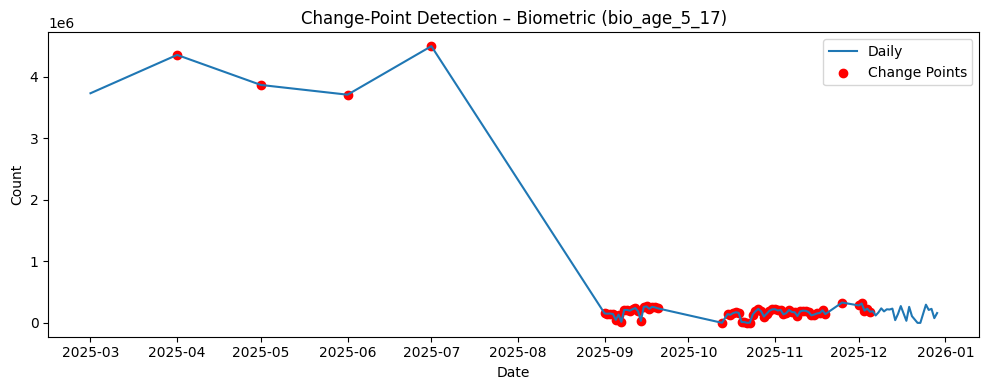

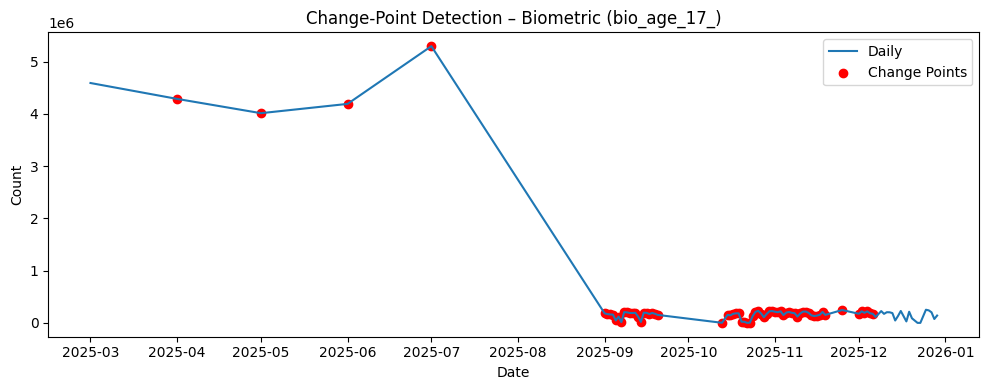

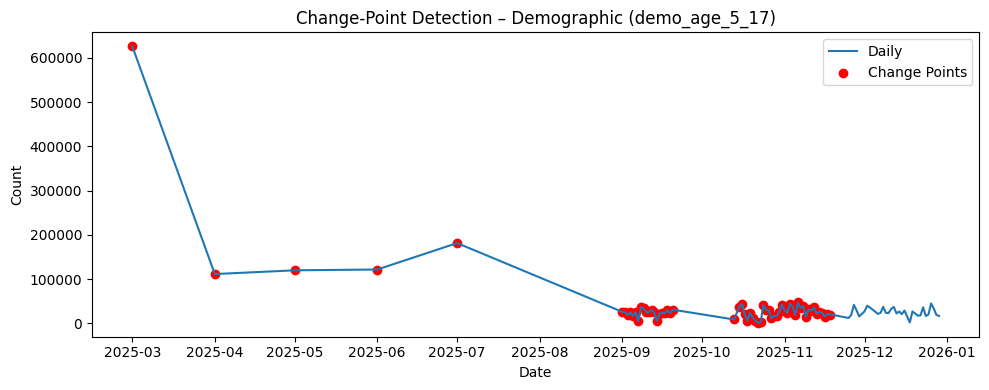

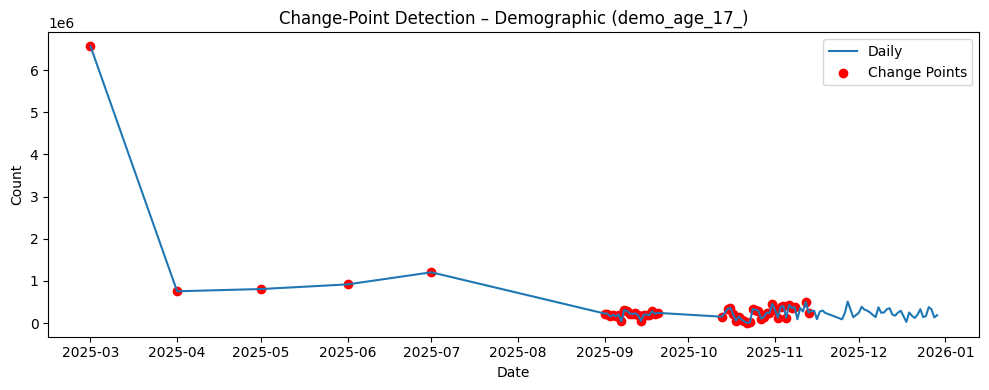

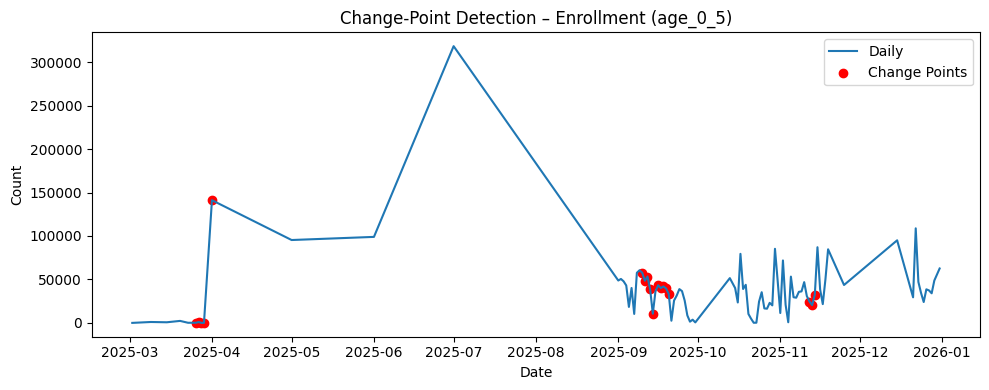

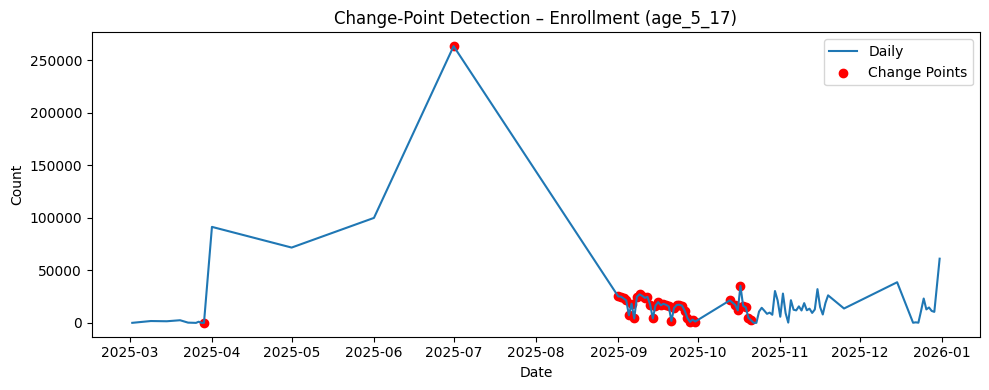

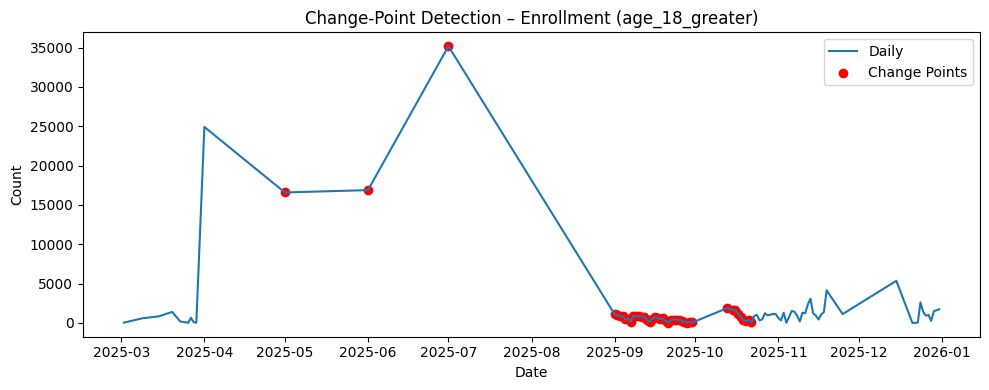

In [21]:
DATASETS = {
    "Biometric": {
        "df": bio_daily,
        "columns": COLUMN_ROLES["biometric"]
    },
    "Demographic": {
        "df": demo_daily,
        "columns": COLUMN_ROLES["demographic"]
    },
    "Enrollment": {
        "df": enr_daily,
        "columns": COLUMN_ROLES["enrollment"]
    }
}

for dataset_name, config in DATASETS.items():
    df = config["df"]
    cols = config["columns"]
    
    for col in cols:
        plot_change_points(
            df,
            col,
            title=f"Change-Point Detection – {dataset_name} ({col})"
        )


Change-point detection across biometric, demographic, and enrollment datasets reveals discrete moments of structural behavioral shifts, supporting the presence of sustained system changes rather than isolated anomalies.

In [22]:
top_states = ["Uttar Pradesh", "Maharashtra", "Bihar"]


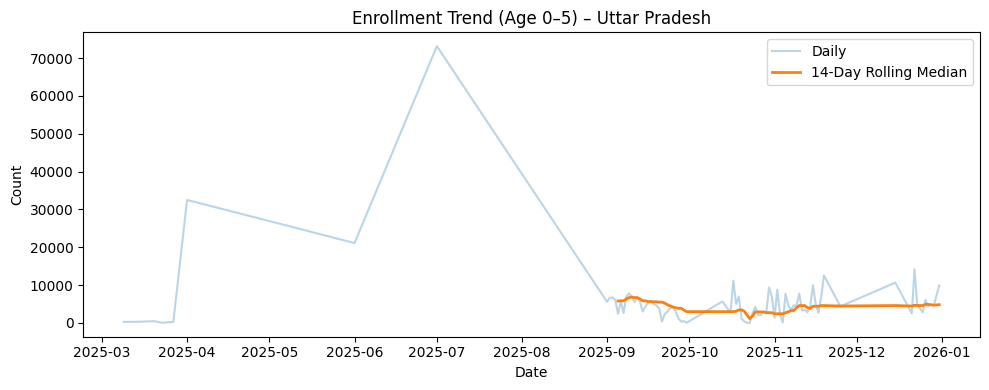

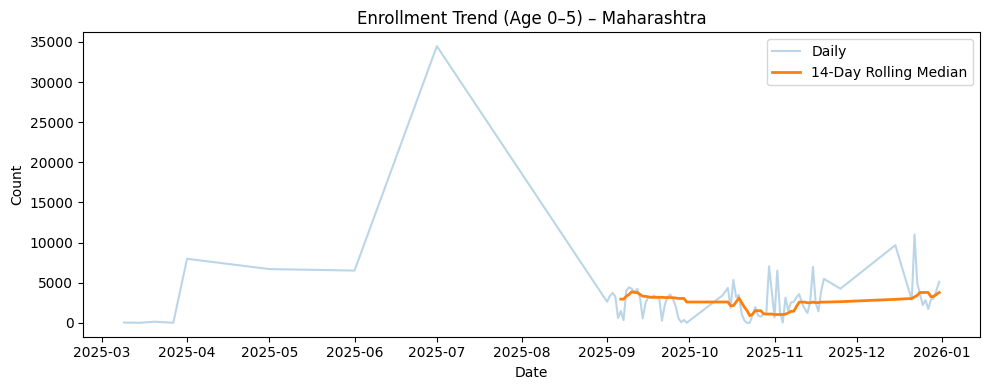

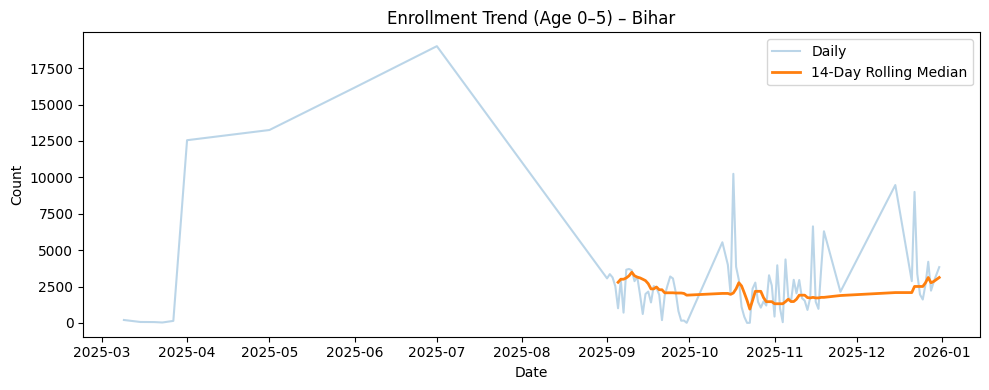

In [23]:
for state in top_states:
    state_df = (
        enrollment_df[enrollment_df["state"] == state]
        .groupby("date")["age_0_5"]
        .sum()
        .reset_index()
    )
    plot_rolling_trend(
        state_df,
        "age_0_5",
        title=f"Enrollment Trend (Age 0–5) – {state}"
    )


Aadhaar-related activity exhibits clear structural regime shifts over time, with large-scale surges followed by stabilization at new baselines, rather than random or purely transient fluctuations.

### Observation from the plots:

Early periods show extremely high activity levels (steep peaks)

These peaks are not sustained

Post a certain point (around Aug–Sep 2025), activity:

Drops sharply

Then stabilizes at lower but non-zero baselines

Exhibits higher volatility around this new baseline

### Interpretation

The system moved from a high-intensity operational phase to a stabilized operational regime

The rolling median flattening does not mean inactivity

It indicates the system found a new equilibrium

This directly answers:

“Did anomalies represent one-off spikes or lasting changes?”

Answer: Lasting changes.

### Across biometric, demographic, and enrollment datasets, you observed:

Consistent change points clustered in similar time windows

Major change points coincide with:

Sharp declines from historical peaks

Transition into lower-variance regimes

Demographic data shows fewer and weaker change points

Biometric and enrollment show strong, repeated change points

### Interpretation

These are system-level structural breaks, not noise

### Likely caused by:

Policy changes

Saturation effects

Operational restructuring

Completion of large enrollment drives

Change-point detection gives you when the system changed — something anomaly detection alone cannot do.

### Key Insight

Regions and metrics with high anomaly counts in Phase 03 also exhibit sustained trend shifts and multiple change points in Phase 04.

### This validates that:

Anomalies were signals of transition, not just outliers

Early anomaly detection could have served as an early warning system

### Enrollment Data

Strongest regime shifts

Clear peak → collapse → stabilization pattern

High operational sensitivity

Best candidate for real-time monitoring

### Biometric Data

Similar but slightly delayed pattern

Indicates downstream operational impact after enrollment drives

### Demographic Data

Most stable

Fewer change points

Acts as a baseline reference, not a stress signal

This hierarchy itself is an important insight.

### Temporal Trend Analysis Conclusion

Temporal trend and change-point analysis reveal that Aadhaar system activity undergoes distinct structural regime shifts rather than isolated fluctuations. Large-scale enrollment and biometric surges are followed by sharp transitions into new, lower-intensity but stable operational baselines. These shifts occur consistently across datasets and align with regions exhibiting high anomaly concentrations, indicating that anomalies act as early indicators of broader system transitions. Demographic data remains comparatively stable, reinforcing its role as a baseline signal. Overall, the findings highlight the importance of temporal monitoring for proactive system oversight and capacity planning.